In [ ]:
from quantanium import *
from openfermion.chem import MolecularData
from openfermionpyscf import PyscfMolecularData, run_pyscf
from openfermion.transforms import jordan_wigner
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Molecule and basis configuration
basis = 'STO-3G'
multiplicity = 1
bond_length = 0.74
geometry = [('H', (0.,0.,0.)),
            ('H', (0.,bond_length,0.))]

In [5]:
# PySCF configuration
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

In [6]:
# Retrieve Molecular data
molecule = MolecularData(
    geometry, basis, multiplicity,
    description="HH length " + str(bond_length))

molecule

In [7]:
molecule = run_pyscf(
    molecule,
    run_scf=run_scf,
    run_mp2=run_mp2,
    run_cisd=run_cisd,
    run_ccsd=run_ccsd,
    run_fci=run_fci)

molecule

In [8]:
qubit_hamiltonian = jordan_wigner(molecule.get_molecular_hamiltonian())
qubit_hamiltonian

-0.09706626816763125 [] +
-0.04530261550379926 [X0 X1 Y2 Y3] +
0.04530261550379926 [X0 Y1 Y2 X3] +
0.04530261550379926 [Y0 X1 X2 Y3] +
-0.04530261550379926 [Y0 Y1 X2 X3] +
0.17141282644776926 [Z0] +
0.16868898170361205 [Z0 Z1] +
0.12062523483390411 [Z0 Z2] +
0.16592785033770338 [Z0 Z3] +
0.1714128264477692 [Z1] +
0.16592785033770338 [Z1 Z2] +
0.12062523483390411 [Z1 Z3] +
-0.22343153690813433 [Z2] +
0.17441287612261575 [Z2 Z3] +
-0.22343153690813433 [Z3]

In [9]:
def openfermion_pauli_extract(pauli_string):
    qubits = [el[0] for el in pauli_string]
    pauli_ops = [el[1] for el in pauli_string]
    return qubits, pauli_ops


def pauli_basis_change(qubits, pauli_ops):    
    c = Circuit()
    for qubit, pauli in zip(qubits, pauli_ops):
        if pauli == "X":
            c.push(GateH(), qubit)
        elif pauli == "Y":
            c.push(GateSDG(), qubit)
            c.push(GateH(), qubit)

    return c


def cnot_ladder(qubits):
    c = Circuit()
    c.push(GateCX(), qubits[:-1], qubits[1:])
    return c
            

def apply_controlled_pauli_rotation(c, pauli_string, coeff, time): # this version takes OpenFermion term as pauli_string
    """Applies a Controlled Pauli rotation e^(-i * coeff * time * P) using basis changes to ZZ...Z rotations"""
    theta = 2 * coeff * time

    qubits, pauli_ops = openfermion_pauli_extract(pauli_string)

    if len(qubits) == 0:
        return c

    qubits = [q+1 for q in qubits]

    cbasis = pauli_basis_change(qubits, pauli_ops)
    c.append(cbasis)

    cladder = cnot_ladder(qubits)
    c.append(cladder)

    c.push(GateCRZ(theta), 0, qubits[-1])

    c.append(cladder.inverse())
    c.append(cbasis.inverse())

    return c

def controlled_trotter(hamiltonian, trotter_steps, time=1.0):
    """Constructs a unitary using Trotterization for a given Hamiltonian."""
    deltat = time / trotter_steps
    c = Circuit()
    for _ in range(trotter_steps):
        for term in hamiltonian.terms:
            c = apply_controlled_pauli_rotation(c, term, hamiltonian.terms[term], deltat)
    return c


In [10]:
def qpe_circuit(ncounting, chamiltonian):
    counting = range(ncounting)
    ndata = chamiltonian.num_qubits - 1
    data = range(ncounting, ncounting + ndata)
    
    # initialization
    c = Circuit()
    c.push(GateH(), range(ncounting))

    for i,j in enumerate(range(ncounting)):
        power = 2**i
        for _ in range(power):
            c.push(chamiltonian, i, *data)

    c.push(QFT(ncounting), *counting)

    return c

In [11]:
trotter_steps = 1
ncounting = 8
trotter_parameter = 10

@gatedecl("chamiltonian")
def controlled_hamiltonian():
    return controlled_trotter(qubit_hamiltonian, trotter_steps,
                              time = 1.0 / trotter_parameter)

qpec = qpe_circuit(ncounting, controlled_hamiltonian())

In [12]:
nelectrons = 2

finalc = Circuit()
finalc.push(GateX(), range(ncounting, ncounting + nelectrons))
finalc.append(qpec)
finalc.push(Measure(), range(ncounting), range(ncounting))

12-qubit circuit with 274 instructions:
├── X @ q[8]
├── X @ q[9]
├── H @ q[0]
├── H @ q[1]
├── H @ q[2]
├── H @ q[3]
├── H @ q[4]
├── H @ q[5]
├── H @ q[6]
├── H @ q[7]
├── chamiltonian() @ q[0,8,9,10,11]
├── chamiltonian() @ q[1,8,9,10,11]
├── chamiltonian() @ q[1,8,9,10,11]
├── chamiltonian() @ q[2,8,9,10,11]
├── chamiltonian() @ q[2,8,9,10,11]
├── chamiltonian() @ q[2,8,9,10,11]
├── chamiltonian() @ q[2,8,9,10,11]
├── chamiltonian() @ q[3,8,9,10,11]
├── chamiltonian() @ q[3,8,9,10,11]
⋮   ⋮
└── M @ q[7], c[7]

In [ ]:
res = Quantanium().execute(finalc)
res

QCSResults:
├── simulator: QLEO 0.1.22
├── timings:
│    ├── sample time: 0.000160847s
│    └── apply time: 0.062414091s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"11001100" => 802
│    ├── bs"10111100" => 69
│    ├── bs"11011100" => 30
│    ├── bs"11101100" => 17
│    └── bs"10101100" => 13
├── 1 executions
├── 0 amplitudes
└── 1000 samples

# Analize data

In [14]:
list_energies = []
list_frequencies = []
for bitstring in res.histogram().keys():
    phase = 0
    coef = 1
    for bit in bitstring:
        coef /= 2
        phase += coef * bit
    phase *= 2 * np.pi
    if phase > np.pi:
        phase -= 2 * np.pi
    phase *= trotter_parameter
    phase += qubit_hamiltonian.terms[()]
    list_energies.append(phase)
    list_frequencies.append(res.histogram()[bitstring] / sum(res.histogram().values()))

Text(0.5, 1.0, 'H$_2$ from Hartree-Fock: STO-3G')

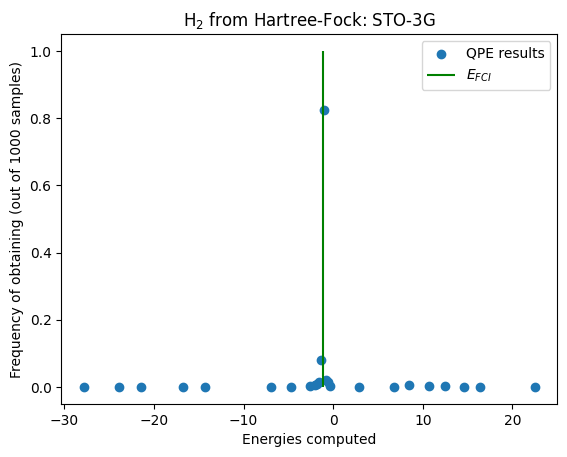

In [15]:
plt.scatter(list_energies, list_frequencies, label="QPE results")
plt.vlines(x=molecule.fci_energy, ymin=0, ymax=1, colors='green', label=r'$E_{FCI}$')
plt.xlabel("Energies computed")
plt.ylabel("Frequency of obtaining (out of " + str(sum(res.histogram().values())) + " samples)")
plt.legend()
plt.title(r"H$_2$ from Hartree-Fock: STO-3G")